In [ ]:
!pip install -q fasttext
!pip install -q sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 802.8 kB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 72.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import fasttext.util
import tensorflow as tf
from tqdm.auto import tqdm
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, pipeline
from transformers import BartTokenizer, BartForConditionalGeneration
from transformers import PegasusTokenizer, PegasusForConditionalGeneration

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/STS Measures/scopus_data/combined.csv')
dataset.shape

(120513, 20)

<Axes: xlabel='Year'>

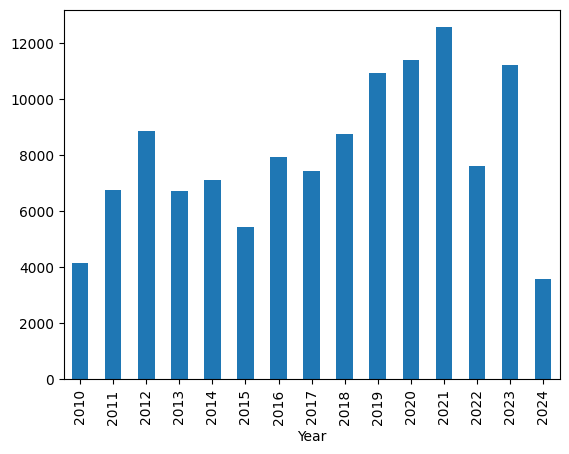

In [ ]:
# Plot data distribution by year
dataset['Year'].value_counts().sort_index().plot(kind='bar')

In [ ]:
years = [2022, 2023, 2024]
dataset = dataset[dataset['Year'].isin(years)]
dataset = dataset.sort_values(by='Year')
dataset.head()

,Authors,Author full names,Author(s) ID,Title,Year,Source title,Volume,Issue,Art. No.,Page start,Page end,Page count,DOI,Link,Abstract,Author Keywords,Index Keywords,Document Type,Source,EID
109284,Salamone F.; Belussi L.; Danza L.; Dobjani E.;...,"Salamone, Francesco (56278189000); Belussi, Lo...",56278189000; 55203944300; 35757331500; 5769674...,BRINGING STUDENTS CLOSER TO THE ISSUES OF INDO...,2022,Acta Polytechnica CTU Proceedings,38,NaN,NaN,424,428,4.0,10.14311/APP.2022.38.0424,https://www.scopus.com/inward/record.uri?eid=2...,The article presents the outcomes of a monitor...,Albania; IEQ; school; survey; sustainability,NaN,Conference paper,Scopus,2-s2.0-85159953290
109286,Setyowati Y.; Kaniawati I.; Sriyati S.; Firda ...,"Setyowati, Yeni (57310538900); Kaniawati, Ida ...",57310538900; 57190936940; 57193863534; 5731089...,Analysis of sustainability consciousness of ju...,2022,AIP Conference Proceedings,2468,NaN,060002,NaN,NaN,NaN,10.1063/5.0103006,https://www.scopus.com/inward/record.uri?eid=2...,Sustainability consciousness is an outcome of ...,NaN,NaN,Conference paper,Scopus,2-s2.0-85146694148
109289,Riani V.R.; Muslim; Rusdiana D.,"Riani, Vine Risa (57222724496); Muslim (572183...",57222724496; 57218334002; 57216266216,Flipped Classroom Integrated ESD Model: To Stu...,2022,AIP Conference Proceedings,2468,NaN,020018,NaN,NaN,NaN,10.1063/5.0102462,https://www.scopus.com/inward/record.uri?eid=2...,The aim of this study is to see the effect of ...,NaN,NaN,Conference paper,Scopus,2-s2.0-85146660402
109290,Tedesco S.; Montacchini E.; Andreotti J.,"Tedesco, Silvia (57206384570); Montacchini, El...",57206384570; 57170868000; 57221109459,EXPERIENCING CIRCULAR DESIGN: STORIES OF AGRI-...,2022,Acta Polytechnica CTU Proceedings,38,NaN,NaN,216,221,5.0,10.14311/APP.2022.38.0216,https://www.scopus.com/inward/record.uri?eid=2...,"The application of the Circular Economy model,...",Agri-food waste; circular design; sustainable ...,NaN,Conference paper,Scopus,2-s2.0-85159948816
109292,Malheiro R.; Morilla A.; Ansolin A.; Fernandes...,"Malheiro, Raphaele (55186346300); Morilla, Aur...",55186346300; 58284465300; 57226298220; 5641155...,THE POTENTIAL USE OF GIANT REED FROM PORTUGAL ...,2022,Acta Polytechnica CTU Proceedings,38,NaN,NaN,235,240,5.0,10.14311/APP.2022.38.0235,https://www.scopus.com/inward/record.uri?eid=2...,The construction sector plays an important rol...,Giant reed; low cost; natural material; sustai...,NaN,Conference paper,Scopus,2-s2.0-85159936561


In [ ]:
# dataset = dataset.reset_index(drop=True)
dataset.shape

(22431, 20)

In [ ]:
# Find records where abstract is missing
missing_abstract = dataset[dataset['Abstract'].isnull()]
missing_abstract

,Authors,Author full names,Author(s) ID,Title,Year,Source title,Volume,Issue,Art. No.,Page start,Page end,Page count,DOI,Link,Abstract,Author Keywords,Index Keywords,Document Type,Source,EID


In [ ]:
print('Word-wise:')
dataset['Abstract Length in Words'] = dataset['Abstract'].apply(lambda x: len(str(x).split()))
print(dataset['Abstract Length in Words'].describe())

print('\nCharacter-wise:')
dataset['Abstract Length in Characters'] = dataset['Abstract'].apply(lambda x: len(str(x)))
print(dataset['Abstract Length in Characters'].describe())

Word-wise:
count    22431.000000
mean       207.996255
std         73.511739
min          3.000000
25%        158.000000
50%        199.000000
75%        245.000000
max       1589.000000
Name: Abstract Length in Words, dtype: float64

Character-wise:
count    22431.000000
mean      1429.084526
std        499.092812
min         23.000000
25%       1095.500000
50%       1362.000000
75%       1676.000000
max      11495.000000
Name: Abstract Length in Characters, dtype: float64


In [ ]:
def cos_sim(v1, v2):
    mag1 = np.linalg.norm(v1)
    mag2 = np.linalg.norm(v2)
    if (not mag1) or (not mag2):
        return 0
    return np.dot(v1, v2) / (mag1 * mag2)

In [ ]:
class MyDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, i):
        text = self.texts[i]
        text_len = len(text)
        min_length = int(0.05 * text_len)
        max_length = int(0.3 * text_len)
        # retunr text
        return text, min_length, max_length

def collate_fn(batch):
    texts, min_lengths, max_lengths = zip(*batch)
    return list(texts), list(min_lengths), list(max_lengths)

In [ ]:
# dataset = dataset[:1000]
abstracts = dataset['Abstract'].tolist()

# Summarization

In [ ]:
# model_name = 'google/pegasus-xsum'  # or 'google/pegasus-cnn_dailymail'
# model = PegasusForConditionalGeneration.from_pretrained(model_name).to(device)
# tokenizer = PegasusTokenizer.from_pretrained(model_name)

In [ ]:
model_name = "facebook/bart-large-cnn"
model = BartForConditionalGeneration.from_pretrained(model_name).to(device)
tokenizer = BartTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
# dataset = dataset[:15]

In [ ]:
dataset.head()

,Authors,Author full names,Author(s) ID,Title,Year,Source title,Volume,Issue,Art. No.,Page start,...,DOI,Link,Abstract,Author Keywords,Index Keywords,Document Type,Source,EID,Abstract Length in Words,Abstract Length in Characters
109284,Salamone F.; Belussi L.; Danza L.; Dobjani E.;...,"Salamone, Francesco (56278189000); Belussi, Lo...",56278189000; 55203944300; 35757331500; 5769674...,BRINGING STUDENTS CLOSER TO THE ISSUES OF INDO...,2022,Acta Polytechnica CTU Proceedings,38,NaN,NaN,424,...,10.14311/APP.2022.38.0424,https://www.scopus.com/inward/record.uri?eid=2...,The article presents the outcomes of a monitor...,Albania; IEQ; school; survey; sustainability,NaN,Conference paper,Scopus,2-s2.0-85159953290,207,1385
109286,Setyowati Y.; Kaniawati I.; Sriyati S.; Firda ...,"Setyowati, Yeni (57310538900); Kaniawati, Ida ...",57310538900; 57190936940; 57193863534; 5731089...,Analysis of sustainability consciousness of ju...,2022,AIP Conference Proceedings,2468,NaN,060002,NaN,...,10.1063/5.0103006,https://www.scopus.com/inward/record.uri?eid=2...,Sustainability consciousness is an outcome of ...,NaN,NaN,Conference paper,Scopus,2-s2.0-85146694148,213,1478
109289,Riani V.R.; Muslim; Rusdiana D.,"Riani, Vine Risa (57222724496); Muslim (572183...",57222724496; 57218334002; 57216266216,Flipped Classroom Integrated ESD Model: To Stu...,2022,AIP Conference Proceedings,2468,NaN,020018,NaN,...,10.1063/5.0102462,https://www.scopus.com/inward/record.uri?eid=2...,The aim of this study is to see the effect of ...,NaN,NaN,Conference paper,Scopus,2-s2.0-85146660402,215,1413
109290,Tedesco S.; Montacchini E.; Andreotti J.,"Tedesco, Silvia (57206384570); Montacchini, El...",57206384570; 57170868000; 57221109459,EXPERIENCING CIRCULAR DESIGN: STORIES OF AGRI-...,2022,Acta Polytechnica CTU Proceedings,38,NaN,NaN,216,...,10.14311/APP.2022.38.0216,https://www.scopus.com/inward/record.uri?eid=2...,"The application of the Circular Economy model,...",Agri-food waste; circular design; sustainable ...,NaN,Conference paper,Scopus,2-s2.0-85159948816,171,1153
109292,Malheiro R.; Morilla A.; Ansolin A.; Fernandes...,"Malheiro, Raphaele (55186346300); Morilla, Aur...",55186346300; 58284465300; 57226298220; 5641155...,THE POTENTIAL USE OF GIANT REED FROM PORTUGAL ...,2022,Acta Polytechnica CTU Proceedings,38,NaN,NaN,235,...,10.14311/APP.2022.38.0235,https://www.scopus.com/inward/record.uri?eid=2...,The construction sector plays an important rol...,Giant reed; low cost; natural material; sustai...,NaN,Conference paper,Scopus,2-s2.0-85159936561,207,1326


In [ ]:
def fits_in_token_limit(text, max_length=1024):
    inputs = tokenizer(text, truncation=False, padding=False)
    return len(inputs['input_ids']) <= max_length

# Apply the function to filter the dataset
filtered_dataset = dataset[dataset['Abstract'].apply(fits_in_token_limit)]

if filtered_dataset.shape[0] >= dataset.shape[0] * 0.9:
    dataset = filtered_dataset
    print(f"Filtered dataset has {dataset.shape[0]} records.")

Filtered dataset has 22427 records.


In [ ]:
filtered_dataset.shape

(22427, 22)

In [ ]:
# pick 20 random records from the dataset
# random_indices = np.random.choice(dataset.shape[0], size=20, replace=False)
# dataset = dataset[:10]

In [ ]:
texts = dataset['Abstract'].tolist()
my_dataset = MyDataset(texts)
len(texts)

22427

In [ ]:
dataset.head()

,Authors,Author full names,Author(s) ID,Title,Year,Source title,Volume,Issue,Art. No.,Page start,...,DOI,Link,Abstract,Author Keywords,Index Keywords,Document Type,Source,EID,Abstract Length in Words,Abstract Length in Characters
109284,Salamone F.; Belussi L.; Danza L.; Dobjani E.;...,"Salamone, Francesco (56278189000); Belussi, Lo...",56278189000; 55203944300; 35757331500; 5769674...,BRINGING STUDENTS CLOSER TO THE ISSUES OF INDO...,2022,Acta Polytechnica CTU Proceedings,38,NaN,NaN,424,...,10.14311/APP.2022.38.0424,https://www.scopus.com/inward/record.uri?eid=2...,The article presents the outcomes of a monitor...,Albania; IEQ; school; survey; sustainability,NaN,Conference paper,Scopus,2-s2.0-85159953290,207,1385
109286,Setyowati Y.; Kaniawati I.; Sriyati S.; Firda ...,"Setyowati, Yeni (57310538900); Kaniawati, Ida ...",57310538900; 57190936940; 57193863534; 5731089...,Analysis of sustainability consciousness of ju...,2022,AIP Conference Proceedings,2468,NaN,060002,NaN,...,10.1063/5.0103006,https://www.scopus.com/inward/record.uri?eid=2...,Sustainability consciousness is an outcome of ...,NaN,NaN,Conference paper,Scopus,2-s2.0-85146694148,213,1478
109289,Riani V.R.; Muslim; Rusdiana D.,"Riani, Vine Risa (57222724496); Muslim (572183...",57222724496; 57218334002; 57216266216,Flipped Classroom Integrated ESD Model: To Stu...,2022,AIP Conference Proceedings,2468,NaN,020018,NaN,...,10.1063/5.0102462,https://www.scopus.com/inward/record.uri?eid=2...,The aim of this study is to see the effect of ...,NaN,NaN,Conference paper,Scopus,2-s2.0-85146660402,215,1413
109290,Tedesco S.; Montacchini E.; Andreotti J.,"Tedesco, Silvia (57206384570); Montacchini, El...",57206384570; 57170868000; 57221109459,EXPERIENCING CIRCULAR DESIGN: STORIES OF AGRI-...,2022,Acta Polytechnica CTU Proceedings,38,NaN,NaN,216,...,10.14311/APP.2022.38.0216,https://www.scopus.com/inward/record.uri?eid=2...,"The application of the Circular Economy model,...",Agri-food waste; circular design; sustainable ...,NaN,Conference paper,Scopus,2-s2.0-85159948816,171,1153
109292,Malheiro R.; Morilla A.; Ansolin A.; Fernandes...,"Malheiro, Raphaele (55186346300); Morilla, Aur...",55186346300; 58284465300; 57226298220; 5641155...,THE POTENTIAL USE OF GIANT REED FROM PORTUGAL ...,2022,Acta Polytechnica CTU Proceedings,38,NaN,NaN,235,...,10.14311/APP.2022.38.0235,https://www.scopus.com/inward/record.uri?eid=2...,The construction sector plays an important rol...,Giant reed; low cost; natural material; sustai...,NaN,Conference paper,Scopus,2-s2.0-85159936561,207,1326


# Batch Summarization

In [ ]:
def generate_summaries(dataset, summarizer, batch_size=32):
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    summaries = []

    for batch in tqdm(data_loader, total=len(data_loader)):
        batch_summaries = summarizer(
            batch,
            min_length=100,
            max_length=500,
            do_sample=False,
            length_penalty = 1.2,
            num_beams=8,
            early_stopping=True
        )
        summaries.extend([summary['summary_text'] for summary in batch_summaries])

    return summaries

In [ ]:
summarizer = pipeline("summarization", model="facebook/bart-large-cnn", device=device)

In [ ]:
dataset['Summary'] = generate_summaries(my_dataset, summarizer)

# Custom lengths

In [ ]:
# def generate_summaries(dataset, model, tokenizer, length_penalty, num_beams, device, batch_size=64):
#     data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
#     summaries = []

#     for texts, min_lengths, max_lengths in tqdm(data_loader, total=len(data_loader)):
#         inputs = tokenizer(texts, return_tensors='pt', truncation=True, padding=True, max_length=512)
#         input_ids = inputs['input_ids'].to(device)
#         attention_mask = inputs['attention_mask'].to(device)

#         for i, text in enumerate(texts):
#             summary_ids = model.generate(
#                 input_ids=input_ids[i:i+1],
#                 attention_mask=attention_mask[i:i+1],
#                 min_length=min_lengths[i],
#                 max_length=max_lengths[i],
#                 length_penalty=length_penalty,
#                 num_beams=num_beams,
#                 early_stopping=True
#             )
#             summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
#             summaries.append(summary)

#     return summaries

In [ ]:
# length_penalty = 1.2  # Adjust length penalty as needed
# num_beams = 8  # Adjust number of beams as needed

# dataset['Summary'] = generate_summaries(my_dataset, model, tokenizer, length_penalty, num_beams, device)

In [ ]:
for index, row in dataset.iterrows():
    print(f"Abstract: {row['Abstract']}")
    print(f"Summary: {row['Summary']}")
    print()
    break

Abstract: Globally, cities are responsible for most of the world’s energy consumption and most of the carbon dioxide emissions. Therefore, the efficient transformation of urban energy systems is becoming a crucial step towards carbon neutrality and more effective climate protection. The Positive Energy District (PED) concept has been pointed out as one of the key principles of this path. The Positive Energy District concept leads towards an integrated and sustainable urban development with an emphasis on the use of renewable energy sources and attention shifting from energy performance at the level of individual buildings to the level of the entire district. However, PEDs represent a relatively new and still not sufficiently explored area in the field of sustainable development. The aim of this paper is to describe the technical part of the new holistic assessment and innovative process of stakeholder engagement to identify Positive Energy Districts in the early development phase that 

In [ ]:
# save the csv
dataset.to_csv('/content/drive/MyDrive/STS Measures/scopus_data/bart_summary.csv', index=False)

# Universal Sentence Encoder (USE)

In [ ]:
# Load the USE model
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
use_embeddings = use_model(abstracts)

In [ ]:
use_similarity_matrix = cosine_similarity(use_embeddings)
print("USE Similarity Score between first two abstracts:", use_similarity_matrix[0, 1])

In [ ]:
def get_use_query_embedding(query):
    return use_model([query]).numpy()

# SentenceTransformers (BERT)



In [ ]:
# Load the Sentence-BERT model
sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2', device=device)

In [ ]:
# Generate embeddings
sbert_embeddings = sbert_model.encode(abstracts, convert_to_tensor=True, device=device)
sbert_embeddings = sbert_embeddings.cpu().numpy()

In [ ]:
sbert_similarity_matrix = cosine_similarity(sbert_embeddings)

In [ ]:
print("SBERT Similarity Score between first two abstracts:", sbert_similarity_matrix[0, 1])

In [ ]:
def get_sbert_query_embedding(query):
    query_embedding = sbert_model.encode([query], convert_to_tensor=True, device=device)
    return query_embedding.cpu().numpy()

# FastText

In [ ]:
# fasttext.util.download_model('en', if_exists='ignore')  # English
fasttext_model = fasttext.load_model('/content/drive/MyDrive/STS Measures/cc.en.300.bin')



> Averaging based embedding



In [ ]:
def get_fasttext_embedding(text):
    words = text.split()
    word_vecs = [fasttext_model.get_word_vector(word) for word in words]
    return sum(word_vecs) / len(word_vecs)

In [ ]:
print("Generating FastText embeddings...")
fasttext_embeddings = [get_fasttext_embedding(abstract) for abstract in abstracts]

In [ ]:
def get_fasttext_query_embedding(query):
    return get_fasttext_embedding(query).reshape(1, -1)

# GloVe

In [ ]:
# Load GloVe embeddings
def load_glove_model(glove_file):
    print("Loading GloVe model...")
    glove_model = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array([float(val) for val in split_line[1:]])
            glove_model[word] = embedding
    print("GloVe model loaded.")
    return glove_model

glove_model = load_glove_model('/content/drive/MyDrive/STS Measures/glove.6B.300d.txt')

In [ ]:
def get_glove_embedding(text, glove_model):
    words = text.split()
    word_vecs = [glove_model[word] for word in words if word in glove_model]
    if len(word_vecs) == 0:  # handle cases where none of the words are in the GloVe model
        return np.zeros(300)
    return np.mean(word_vecs, axis=0)

print("Generating GloVe embeddings...")
glove_embeddings = [get_glove_embedding(abstract, glove_model) for abstract in abstracts]

In [ ]:
def get_glove_query_embedding(query):
    return get_glove_embedding(query, glove_model).reshape(1, -1)

# ELMo

In [ ]:
print("Loading ELMo model...")
elmo_model = hub.load("https://tfhub.dev/google/elmo/3")

In [ ]:
def get_elmo_embeddings(texts):
    elmo_embeddings = []
    for text in texts:
        elmo_output = elmo_model.signatures['default'](tf.constant([text]))['elmo']
        elmo_embedding = tf.reduce_mean(elmo_output, axis=1).numpy()
        elmo_embeddings.append(elmo_embedding)
    return np.array(elmo_embeddings).reshape(len(texts), -1)

In [ ]:
print("Generating ELMo embeddings...")
elmo_embeddings = get_elmo_embeddings(abstracts)

In [ ]:
def get_elmo_query_embedding(query):
    return get_elmo_embeddings([query]).reshape(1, -1)

# Testing Section

In [ ]:
def get_top_n_similar_abstracts(query_embedding, abstract_embeddings, top_n=5):
    # Compute cosine similarity
    similarity_scores = cosine_similarity(query_embedding, abstract_embeddings).flatten()
    # Get the top N most similar abstracts
    top_n_indices = similarity_scores.argsort()[-top_n:][::-1]
    return top_n_indices, similarity_scores[top_n_indices]

# Function to search abstracts
def search_abstracts(query, method='use', top_n=5):
    if method == 'use':
        query_embedding = get_use_query_embedding(query)
        abstract_embeddings = use_embeddings
    elif method == 'sbert':
        query_embedding = get_sbert_query_embedding(query)
        abstract_embeddings = sbert_embeddings
    elif method == 'fasttext':
        query_embedding = get_fasttext_query_embedding(query)
        abstract_embeddings = fasttext_embeddings
    elif method == 'glove':
        query_embedding = get_glove_query_embedding(query)
        abstract_embeddings = glove_embeddings
    elif method == 'elmo':
        query_embedding = get_elmo_query_embedding(query)
        abstract_embeddings = elmo_embeddings
    else:
        raise ValueError("Unknown method: choose 'use' or 'sbert'")

    top_n_indices, top_n_scores = get_top_n_similar_abstracts(query_embedding, abstract_embeddings, top_n)

    for i, idx in enumerate(top_n_indices):
        print(f"Rank {i+1}:")
        print(f"Abstract: {abstracts[idx]}")
        print(f"Similarity Score: {top_n_scores[i]}")
        print()

USE test

In [ ]:
query = "sustainable developement"
search_abstracts(query, method='use', top_n=5)

SentenceTransformers

In [ ]:
query = "sustainable developement"
search_abstracts(query, method='sbert', top_n=5)

FastText test

In [ ]:
query = "sustainable developement"
search_abstracts(query, method='fasttext', top_n=5)

ELMo test

In [ ]:
query = "sustainable developement"
search_abstracts(query, method='elmo', top_n=5)

# Experimental Section

> Text Pre-processing



In [ ]:
exit(0)

In [ ]:
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
def remove_stopwords(stop_words, tokens):
    res = []
    for token in tokens:
        if not token in stop_words:
            res.append(token)
    return res

def process_text(text):
    text = text.encode('ascii', errors='ignore').decode()
    text = text.lower()
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'#+', ' ', text )
    text = re.sub(r'@[A-Za-z0-9]+', ' ', text)
    text = re.sub(r"([A-Za-z]+)'s", r"\1 is", text)
    #text = re.sub(r"\'s", " ", text)     text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"won't", "will not ", text)
    text = re.sub(r"isn't", "is not ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip()
    return text

def lemmatize(tokens):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemma_list = []
    for token in tokens:
        lemma = lemmatizer.lemmatize(token, 'v')
        if lemma == token:
            lemma = lemmatizer.lemmatize(token)
        lemma_list.append(lemma)
    # return [ lemmatizer.lemmatize(token, 'v') for token in tokens ]     return lemma_list


def process_all(text):
    text = process_text(text)
    return ' '.join(remove_stopwords(stop_words, text.split()))